# Yelp Reviews: Classification of 1 & 2 vs 5 Stars on Reviews using Catboost

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import warnings
import pandas as pd
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score classification_report, confusion_matrix
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
my_dpi = 96

     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 308 kB 34.6 MB/s 
     |████████████████████████████████| 81 kB 12.4 MB/s 
     |████████████████████████████████| 210 kB 33.1 MB/s 
     |████████████████████████████████| 78 kB 9.8 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
     |████████████████████████████████| 146 kB 79.0 MB/s 
     |████████████████████████████████| 112 kB 24.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=dbb53507d655510f51143cf1f2f00d485218c649fe32839cc96c100386626e53
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri May 13 05:46:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Process format of reviews for word2vec
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [ ]:
# Recode to binary
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Shuffle and sample 1 & 2 star reviews
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
# Shuffle and sample 5 star reviews
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)

# Concat with 1 and 2 star reviews
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(829874, 2)

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

## Word2vec - Reviews: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for text. 
    The transform function generates mean vectors in model pipelines.
    The class has both fit & transform functions for use in a sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        # If using GloVe, the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        # Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Implement a fit method required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        Generates a w2v vector for a set of tokens by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7ff34f764d90>)])

In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value)

    # Vectorize
    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])
    run_time = timer() - start

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    
    return np.mean(cv_scores)       

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

In [ ]:
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0)
    }

    # Define model
    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU', 
        random_state=seed_value,
        **params_catboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
304:	learn: 0.1335290	test: 0.1595517	best: 0.1595517 (304)	total: 8.49s	remaining: 139ms
305:	learn: 0.1334343	test: 0.1595287	best: 0.1595287 (305)	total: 8.52s	remaining: 111ms
306:	learn: 0.1333578	test: 0.1595112	best: 0.1595112 (306)	total: 8.54s	remaining: 83.5ms
307:	learn: 0.1332762	test: 0.1594920	best: 0.1594920 (307)	total: 8.57s	remaining: 55.7ms
308:	learn: 0.1332095	test: 0.1594747	best: 0.1594747 (308)	total: 8.6s	remaining: 27.8ms
309:	learn: 0.1330866	test: 0.1594661	best: 0.1594661 (309)	total: 8.63s	remaining: 0us
bestTest = 0.1594661456
bestIteration = 309
- Validation logloss: 0.16042108179727405
0:	learn: 0.6359443	test: 0.6361527	best: 0.6361527 (0)	total: 54.8ms	remaining: 16.9s
1:	learn: 0.5859534	test: 0.5863539	best: 0.5863539 (1)	total: 109ms	remaining: 16.8s
2:	learn: 0.5427806	test: 0.5432815	best: 0.5432815 (2)	total: 154ms	remaining: 15.7s
3:	learn: 0.5047027	test: 0.5053351	best: 0.5053351 (3)	total: 1

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_depth': 'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg': 'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf': 'min_data_in_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_one_hot_max_size': 'one_hot_max_size'}, 
                 inplace=True)
trials_df.rename(columns={'params_scale_pos_weight': 'scale_pos_weight'}, 
                 inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment.csv', 
                 index=False)

    iteration   logloss             datetime_start          datetime_complete  \
52         52  0.160409 2022-05-13 07:06:50.583015 2022-05-13 07:08:25.880561   
84         84  0.160421 2022-05-13 07:57:14.258533 2022-05-13 07:58:50.103699   
68         68  0.160633 2022-05-13 07:31:59.624199 2022-05-13 07:33:35.005860   
91         91  0.160700 2022-05-13 08:08:15.149929 2022-05-13 08:09:51.289368   
69         69  0.160773 2022-05-13 07:33:35.005984 2022-05-13 07:35:10.167786   
..        ...       ...                        ...                        ...   
7           7  0.688825 2022-05-13 05:57:56.528254 2022-05-13 05:59:32.976857   
1           1  0.689896 2022-05-13 05:48:42.866717 2022-05-13 05:50:18.933607   
5           5  0.690068 2022-05-13 05:54:52.296596 2022-05-13 05:56:26.410358   
60         60  0.691818 2022-05-13 07:19:35.925069 2022-05-13 07:21:06.003837   
23         23  0.692705 2022-05-13 06:22:29.600686 2022-05-13 06:24:01.846138   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

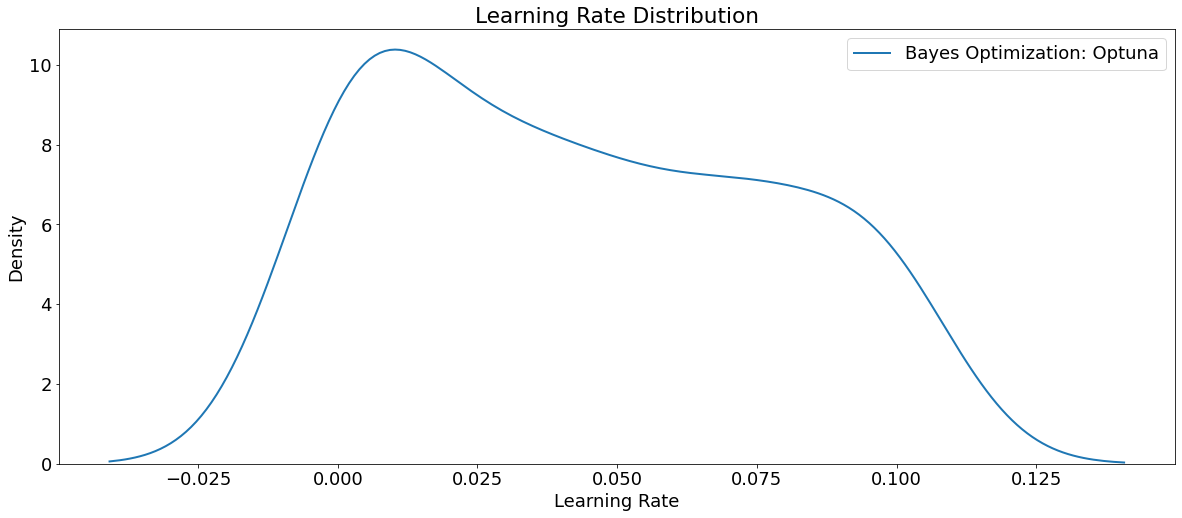

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

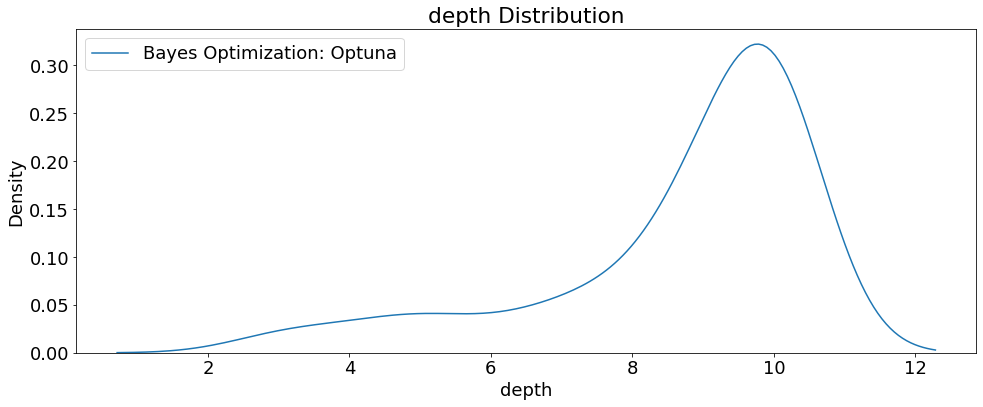

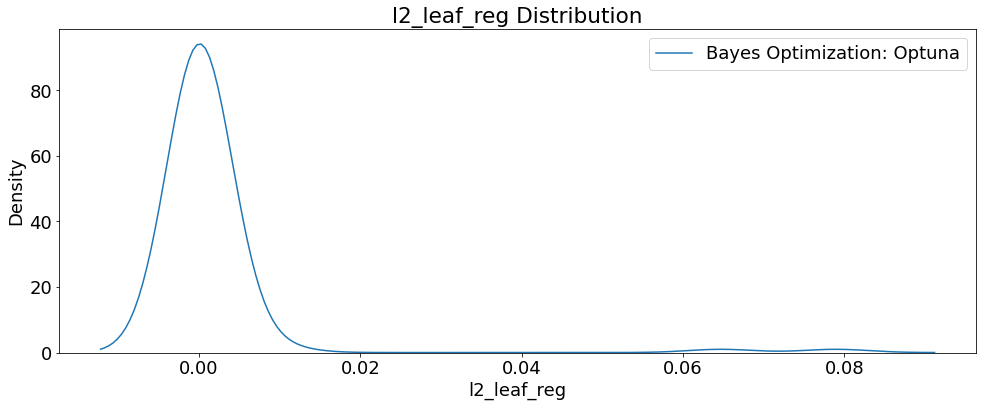

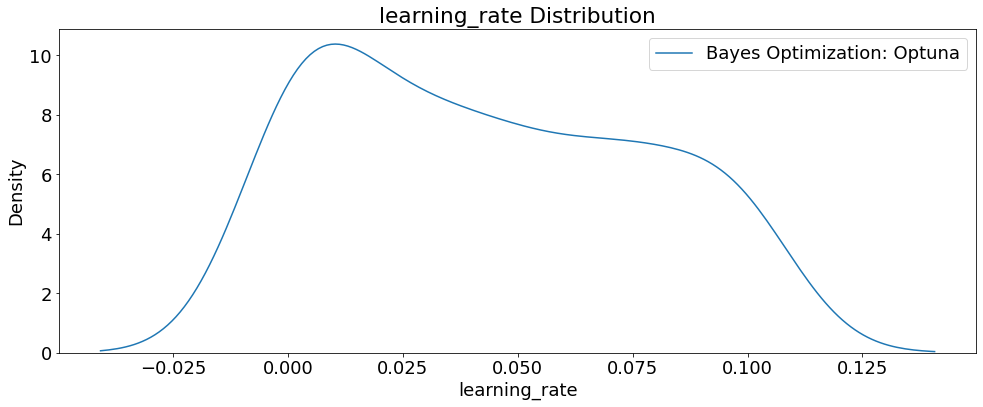

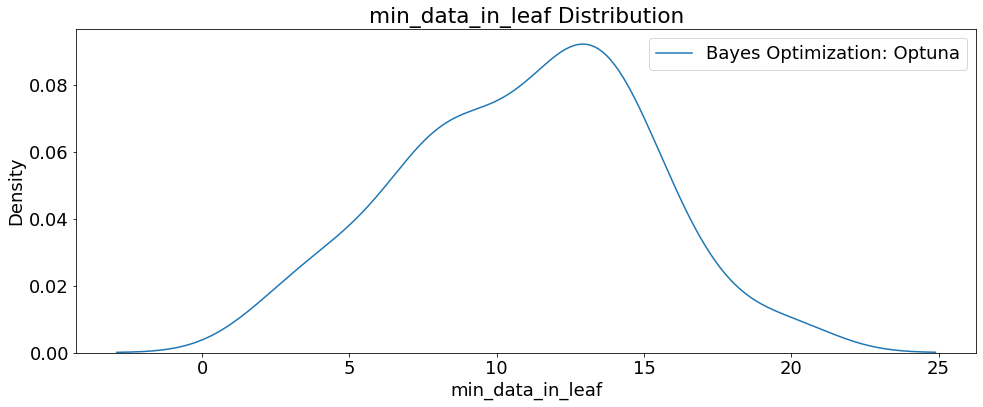

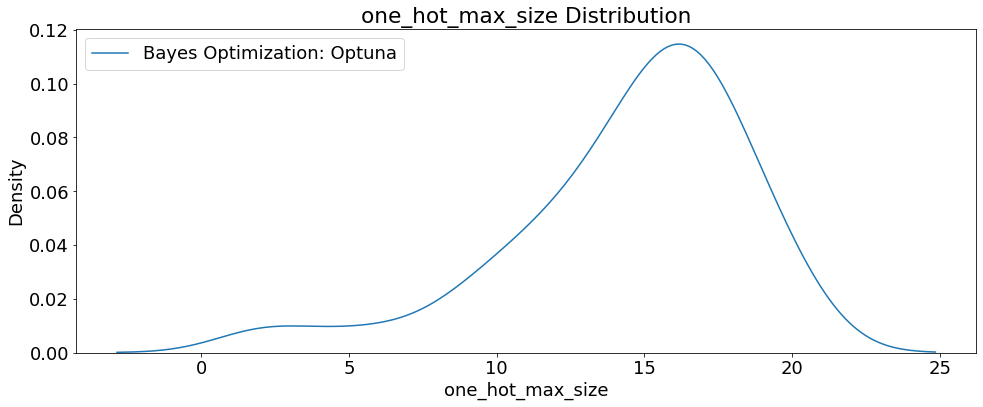

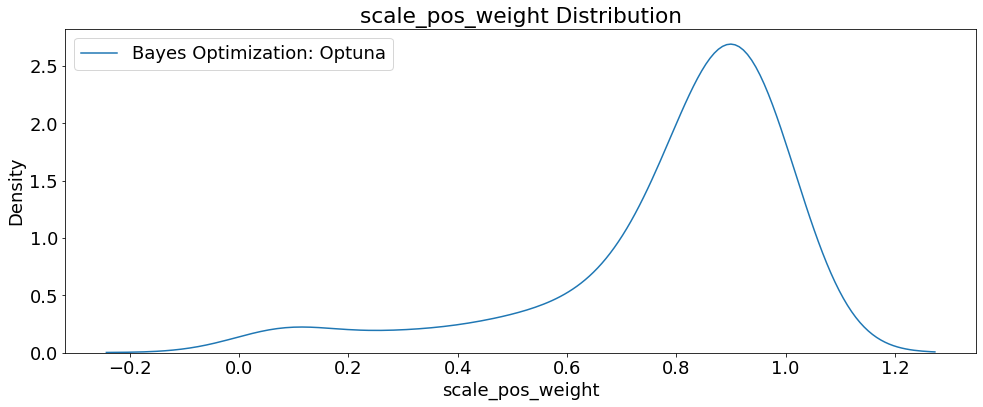

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration', 'n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

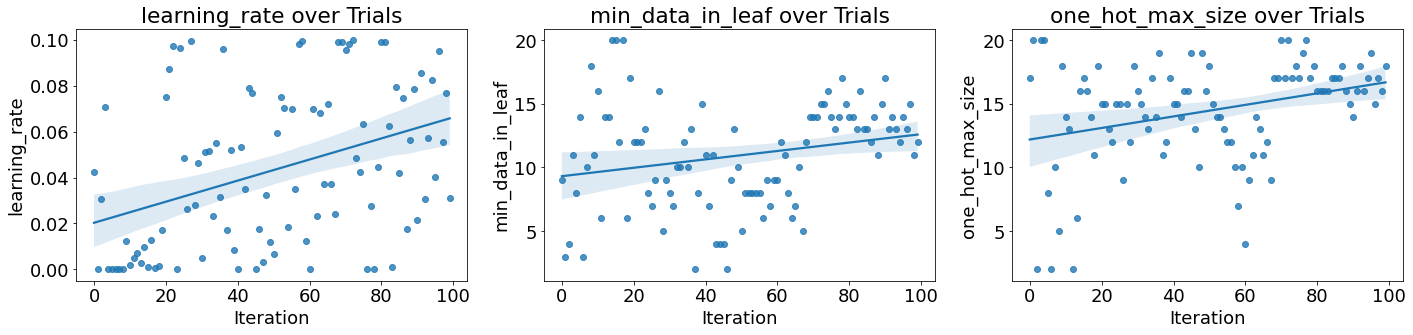

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

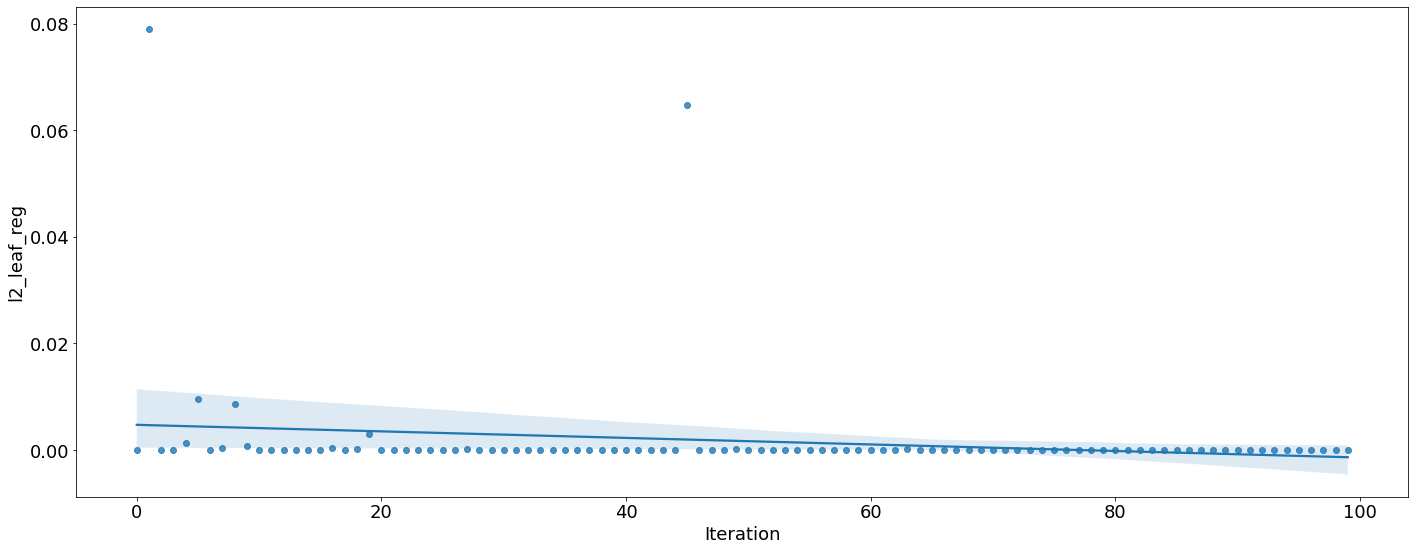

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=trials_df, 
                 label='Bayes Optimization') 
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 10,
 'iterations': 290,
 'l2_leaf_reg': 1.0901217292554234e-05,
 'learning_rate': 0.0751512132184808,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 8,
 'one_hot_max_size': 14,
 'random_state': 42,
 'scale_pos_weight': 0.9977759070485601}

In [ ]:
# Set up target and features 
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(task_type='GPU', 
                                early_stopping_rounds=100,
                                rsm=1,
                                logging_level='Silent', 
                                **params)
# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from Catboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    331950
         1.0       0.95      0.95      0.95    331949

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[314846  17104]
 [ 17996 313953]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82987
         1.0       0.94      0.94      0.94     82988

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[77971  5016]
 [ 5295 77693]]


Accuracy score: train: 0.947, test: 0.938
Precision score: train: 0.948, test: 0.939
Recall score: train: 0.946, test

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93788 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    52
logloss                                0.160409
datetime_start       2022-05-13 07:06:50.583015
datetime_complete    2022-05-13 07:08:25.880561
duration                 0 days 00:01:35.297546
depth                                        10
n_estimators                                290
l2_leaf_reg                            0.000011
learning_rate                          0.075151
min_data_in_leaf                              8
one_hot_max_size                             14
scale_pos_weight                       0.997776
state                                  COMPLETE
Name: 0, dtype: object


## Word2vec - Sentiment: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_sentPosNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv
pl = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0)
    }

    # Define model
    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU', 
        random_state=seed_value,
        **params_catboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=51)
# Number of previously finished trials: 49
# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
21:	learn: 0.3518081	test: 0.3530000	best: 0.3530000 (21)	total: 383ms	remaining: 7.11s
22:	learn: 0.3448389	test: 0.3460509	best: 0.3460509 (22)	total: 399ms	remaining: 7.07s
23:	learn: 0.3381490	test: 0.3393831	best: 0.3393831 (23)	total: 418ms	remaining: 7.07s
24:	learn: 0.3320717	test: 0.3333100	best: 0.3333100 (24)	total: 436ms	remaining: 7.07s
25:	learn: 0.3262447	test: 0.3275220	best: 0.3275220 (25)	total: 453ms	remaining: 7.03s
26:	learn: 0.3207795	test: 0.3220735	best: 0.3220735 (26)	total: 469ms	remaining: 7s
27:	learn: 0.3155527	test: 0.3168834	best: 0.3168834 (27)	total: 485ms	remaining: 6.96s
28:	learn: 0.3105929	test: 0.3119467	best: 0.3119467 (28)	total: 503ms	remaining: 6.95s
29:	learn: 0.3058400	test: 0.3071953	best: 0.3071953 (29)	total: 522ms	remaining: 6.96s
30:	learn: 0.3015087	test: 0.3028696	best: 0.3028696 (30)	total: 539ms	remaining: 6.94s
31:	learn: 0.2974100	test: 0.2987802	best: 0.2987802 (31)	total: 556ms	r

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_depth': 'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg': 'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf': 'min_data_in_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_one_hot_max_size': 'one_hot_max_size'}, 
                 inplace=True)
trials_df.rename(columns={'params_scale_pos_weight': 'scale_pos_weight'}, 
                 inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv', 
                 index=False)

    iteration   logloss             datetime_start          datetime_complete  \
58         58  0.160526 2022-05-14 12:31:28.674318 2022-05-14 12:33:07.087235   
75         75  0.160633 2022-05-14 12:59:01.852021 2022-05-14 13:00:40.458200   
96         96  0.160660 2022-05-14 13:33:35.427589 2022-05-14 13:35:14.952976   
74         74  0.161213 2022-05-14 12:57:23.069310 2022-05-14 12:59:01.851889   
86         86  0.161389 2022-05-14 13:16:59.751912 2022-05-14 13:18:38.730543   
..        ...       ...                        ...                        ...   
3           3  0.692699 2022-05-14 03:45:56.573916 2022-05-14 03:47:37.770798   
30         30  0.692887 2022-05-14 11:15:27.855206 2022-05-14 11:16:59.836745   
25         25  0.706850 2022-05-14 11:07:42.124348 2022-05-14 11:09:17.962009   
21         21       NaN 2022-05-14 04:16:56.419436                        NaT   
48         48       NaN 2022-05-14 11:44:28.423948                        NaT   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

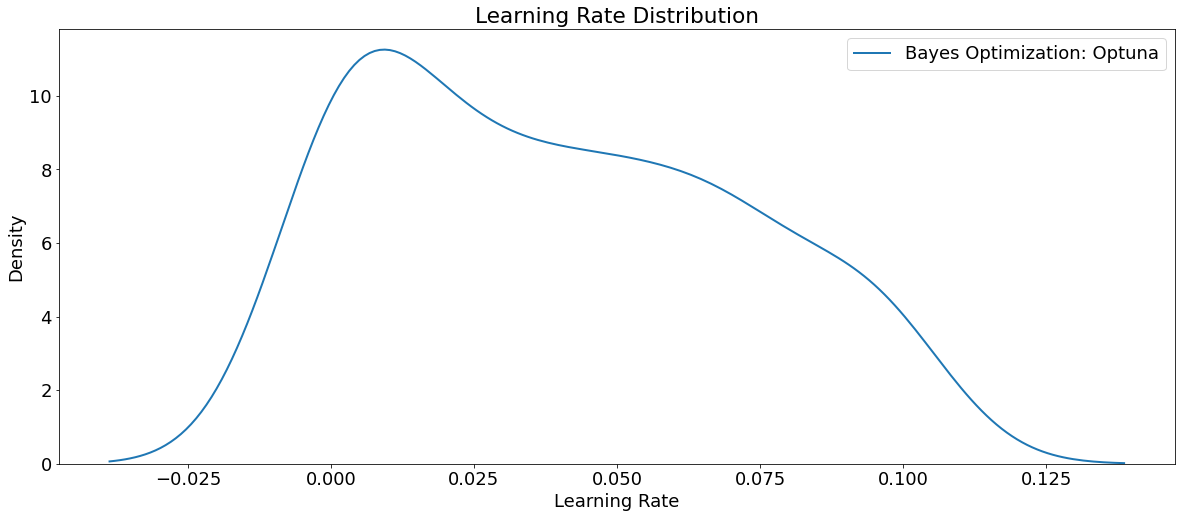

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

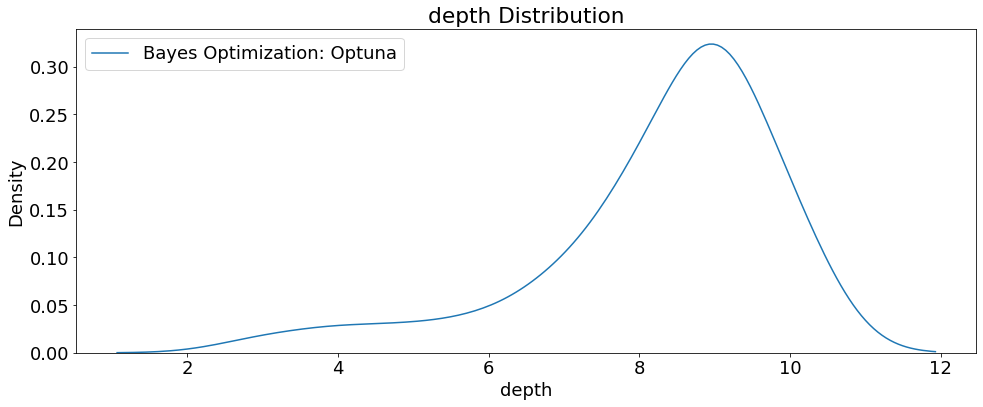

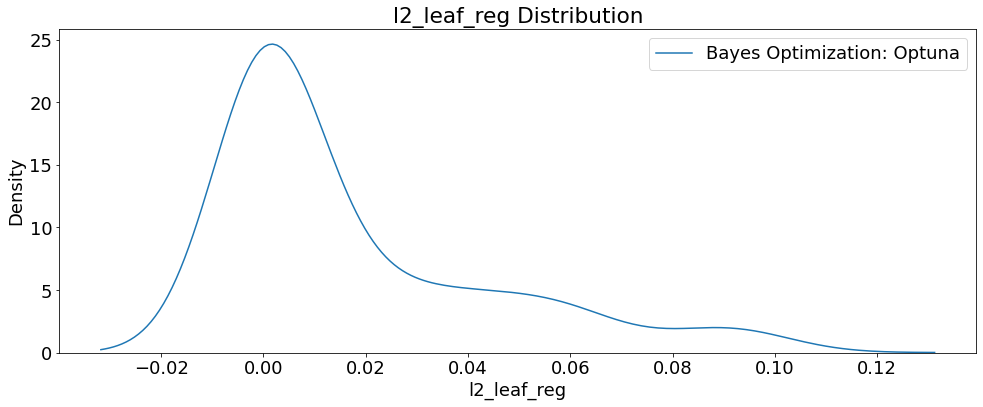

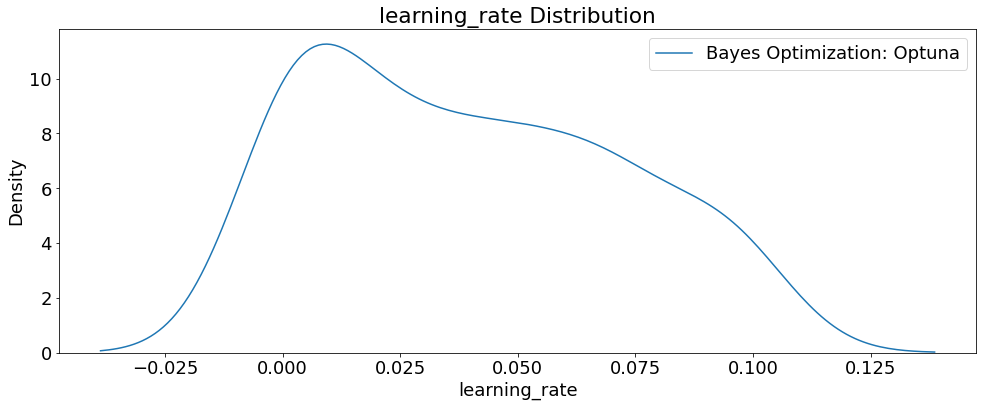

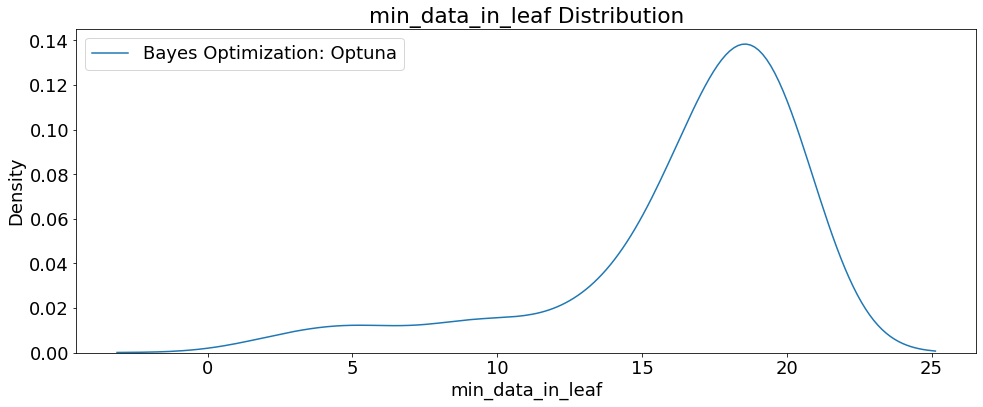

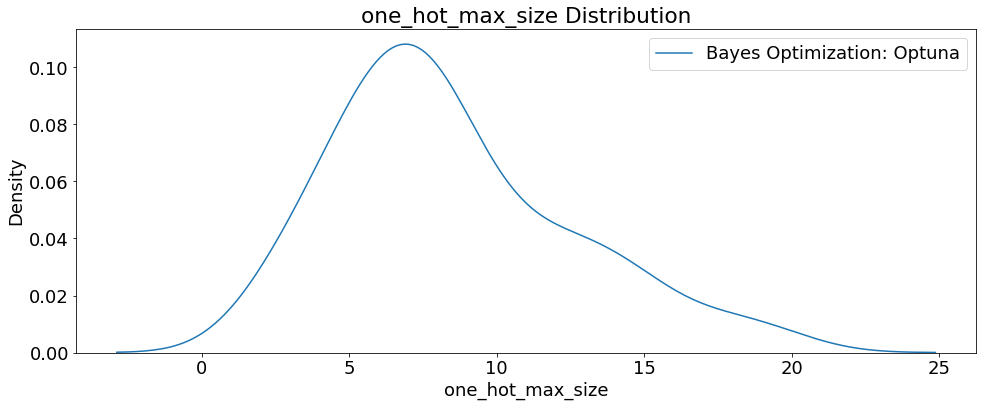

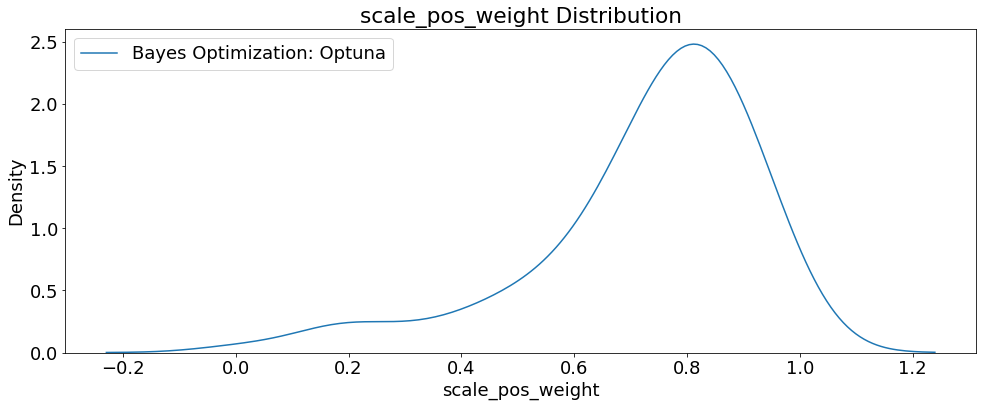

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

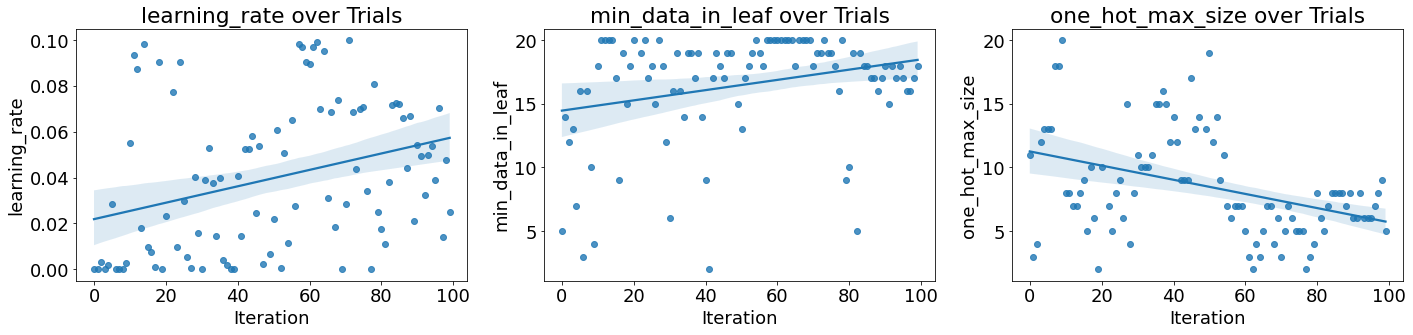

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

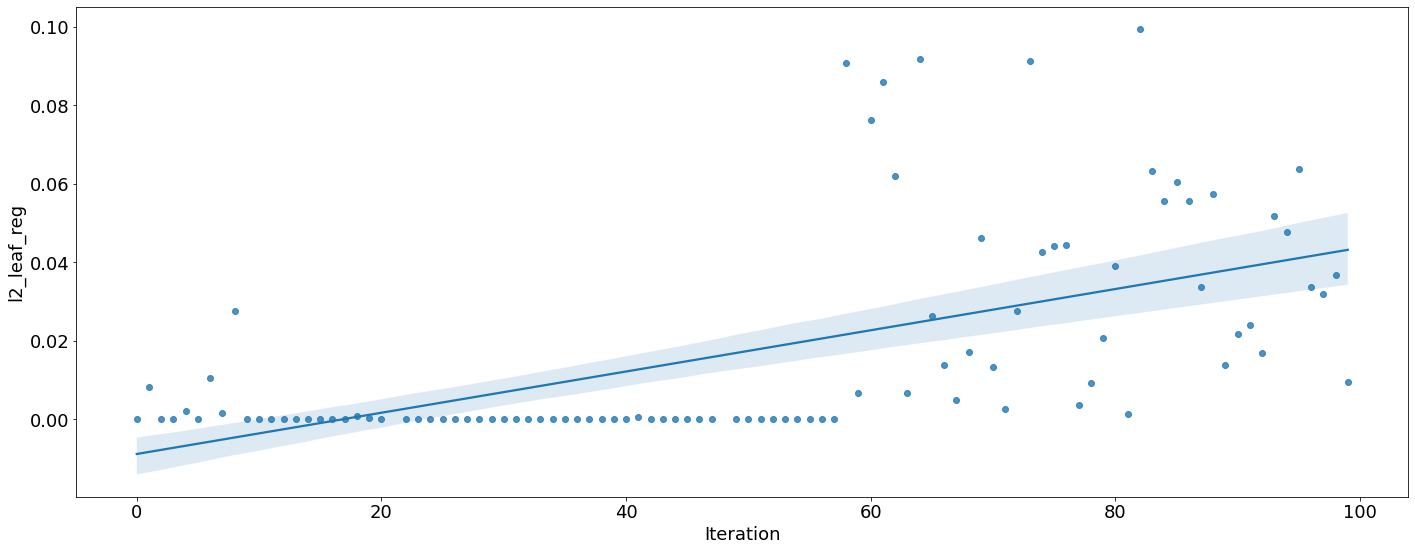

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=trials_df, 
                 label='Bayes Optimization') 
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 9,
 'iterations': 400,
 'l2_leaf_reg': 0.09068084631501748,
 'learning_rate': 0.09709794282866532,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 20,
 'one_hot_max_size': 7,
 'random_state': 42,
 'scale_pos_weight': 0.8156227654890045}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/Models/ML/Catboost/ReviewStars/Model_PKL


In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(task_type='GPU', 
                                early_stopping_rounds=100,
                                rsm=1,
                                logging_level='Silent', 
                                **params)
# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from Catboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    331950
         1.0       0.95      0.94      0.95    331949

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[317002  14948]
 [ 19815 312134]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     82987
         1.0       0.94      0.93      0.94     82988

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78392  4595]
 [ 5815 77173]]


Accuracy score: train: 0.948, test: 0.937
Precision score: train: 0.954, test: 0.944
Recall score: train: 0.940, test

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93728 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    58
logloss                                0.160526
datetime_start       2022-05-14 12:31:28.674318
datetime_complete    2022-05-14 12:33:07.087235
duration                 0 days 00:01:38.412917
depth                                       9.0
n_estimators                              400.0
l2_leaf_reg                            0.090681
learning_rate                          0.097098
min_data_in_leaf                           20.0
one_hot_max_size                            7.0
scale_pos_weight                       0.815623
state                                  COMPLETE
Name: 0, dtype: object
